In [96]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
import os

# From tensorflow
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , Dropout , Flatten , Conv2D , MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# Import Sklearn
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import classification_report

In [97]:
files=glob('../input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/*/*/*')

In [98]:
len(files)

18000

In [99]:
files[:3]

['../input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/Hourse Mackerel/Hourse Mackerel/00929.png',
 '../input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/Hourse Mackerel/Hourse Mackerel/00704.png',
 '../input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/Hourse Mackerel/Hourse Mackerel/00562.png']

In [100]:
File_Path = pd.Series(files).astype(str)

In [101]:
# Splitting the Labels From Paths
Labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1],files))
Labels = pd.Series(Labels)

In [102]:
Labels[:2]

0    Hourse Mackerel
1    Hourse Mackerel
dtype: object

In [103]:
# Concatinating Labels and images
df = pd.concat([File_Path,Labels],axis=1)
df.columns = ['image', 'label']

In [104]:
df

,image,label
0,../input/a-large-scale-fish-dataset/Fish_Datas...,Hourse Mackerel
1,../input/a-large-scale-fish-dataset/Fish_Datas...,Hourse Mackerel
2,../input/a-large-scale-fish-dataset/Fish_Datas...,Hourse Mackerel
3,../input/a-large-scale-fish-dataset/Fish_Datas...,Hourse Mackerel
4,../input/a-large-scale-fish-dataset/Fish_Datas...,Hourse Mackerel
...,...,...
17995,../input/a-large-scale-fish-dataset/Fish_Datas...,Red Sea Bream GT
17996,../input/a-large-scale-fish-dataset/Fish_Datas...,Red Sea Bream GT
17997,../input/a-large-scale-fish-dataset/Fish_Datas...,Red Sea Bream GT
17998,../input/a-large-scale-fish-dataset/Fish_Datas...,Red Sea Bream GT


 Removing GT images

In [105]:
# Removing GT images
df = df[df["label"].apply(lambda x: x[-2:] != "GT")].reset_index(drop=True)
df

,image,label
0,../input/a-large-scale-fish-dataset/Fish_Datas...,Hourse Mackerel
1,../input/a-large-scale-fish-dataset/Fish_Datas...,Hourse Mackerel
2,../input/a-large-scale-fish-dataset/Fish_Datas...,Hourse Mackerel
3,../input/a-large-scale-fish-dataset/Fish_Datas...,Hourse Mackerel
4,../input/a-large-scale-fish-dataset/Fish_Datas...,Hourse Mackerel
...,...,...
8995,../input/a-large-scale-fish-dataset/Fish_Datas...,Red Sea Bream
8996,../input/a-large-scale-fish-dataset/Fish_Datas...,Red Sea Bream
8997,../input/a-large-scale-fish-dataset/Fish_Datas...,Red Sea Bream
8998,../input/a-large-scale-fish-dataset/Fish_Datas...,Red Sea Bream


In [106]:
df.label.value_counts()

Red Sea Bream         1000
Red Mullet            1000
Black Sea Sprat       1000
Striped Red Mullet    1000
Gilt-Head Bream       1000
Trout                 1000
Sea Bass              1000
Hourse Mackerel       1000
Shrimp                1000
Name: label, dtype: int64

Train test validation split

In [107]:
x_train, x_test = train_test_split(df, test_size=0.2,random_state=30)
x_train, x_val = train_test_split(x_train, test_size=0.2, random_state=30)
print(x_test.shape)
print(x_train.shape)
print(x_val.shape)

(1800, 2)
(5760, 2)
(1440, 2)


# Generating data

In [108]:
img_gen = ImageDataGenerator(rescale = 1./255)

In [109]:
train = img_gen.flow_from_dataframe(dataframe=x_train, 
                                                 x_col='image', y_col='label', 
                                                 target_size=(200,200), color_mode='rgb', 
                                                 class_mode='categorical', shuffle=False)

test = img_gen.flow_from_dataframe(dataframe=x_test, 
                                                x_col='image', y_col='label', 
                                                target_size=(200,200), color_mode='rgb', 
                                                class_mode='categorical', shuffle=False)
val = img_gen.flow_from_dataframe(dataframe=x_val,
                                               x_col='image', y_col='label', 
                                               target_size=(200,200), color_mode='rgb', 
                                               class_mode='categorical',shuffle=False)

Found 5760 validated image filenames belonging to 9 classes.
Found 1800 validated image filenames belonging to 9 classes.
Found 1440 validated image filenames belonging to 9 classes.


# Creating a Keras CNN model

In [110]:
#A Sequential model is appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor.
input_shape=(200,200,3)
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
    #param_number = output_channel_number * (input_channel_number * kernel_height * kernel_width + 1)
    #param_number = 32*(3*3*3+1)=896
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),   # output_shape = math.floor((input_shape - pool_size) / strides) + 1 
    tf.keras.layers.Conv2D(16, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Conv2D(16, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Conv2D(16, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    #param_number = output_channel_number * (input_channel_number + 1)
    #param_number= 512*(1600+1)= 819712
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(9, activation='softmax')
])

model.summary()

# https://towardsdatascience.com/how-to-calculate-the-number-of-parameters-in-keras-models-710683dae0ca

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 198, 198, 32)      896       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 99, 99, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 97, 97, 16)        4624      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 48, 48, 16)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 46, 46, 16)        2320      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 23, 23, 16)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 21, 21, 16)       

In [111]:
#defines the loss function, the optimizer and the metrics
model.compile(optimizer='adam', 
              loss="categorical_crossentropy", 
              metrics=['accuracy']) 

# Training model

In [112]:
history = model.fit(train, validation_data=val, epochs=15)

Epoch 1/15
180/180 [==============================] - 69s 381ms/step - loss: 1.9648 - accuracy: 0.2396 - val_loss: 1.0274 - val_accuracy: 0.6479
Epoch 2/15
180/180 [==============================] - 68s 380ms/step - loss: 1.0124 - accuracy: 0.6262 - val_loss: 0.5674 - val_accuracy: 0.7958
Epoch 3/15
180/180 [==============================] - 69s 386ms/step - loss: 0.5349 - accuracy: 0.8076 - val_loss: 0.4060 - val_accuracy: 0.8632
Epoch 4/15
180/180 [==============================] - 68s 380ms/step - loss: 0.2949 - accuracy: 0.9024 - val_loss: 0.5253 - val_accuracy: 0.8257
Epoch 5/15
180/180 [==============================] - 68s 378ms/step - loss: 0.2063 - accuracy: 0.9330 - val_loss: 0.3018 - val_accuracy: 0.9014
Epoch 6/15
180/180 [==============================] - 69s 381ms/step - loss: 0.1414 - accuracy: 0.9524 - val_loss: 0.1963 - val_accuracy: 0.9361
Epoch 7/15
180/180 [==============================] - 68s 379ms/step - loss: 0.1007 - accuracy: 0.9664 - val_loss: 0.1572 - val_ac

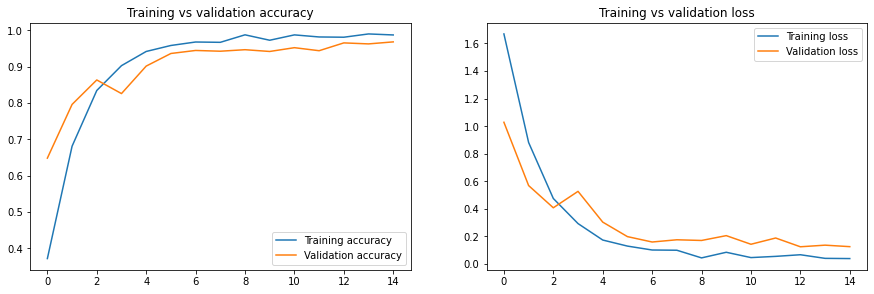

In [113]:
#Plotting Accuracy and Loss 
accuracy = history.history['accuracy']
val_accuracy  = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']
plt.figure(figsize=(15,10))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")


plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.show()

# Prediction

In [114]:
pred = model.predict(test)
pred = np.argmax(pred,axis = 1) 

In [115]:
from sklearn.metrics import classification_report, confusion_matrix

In [116]:
from sklearn.metrics import accuracy_score
accuracy_score(test.labels,pred)

0.955

[]

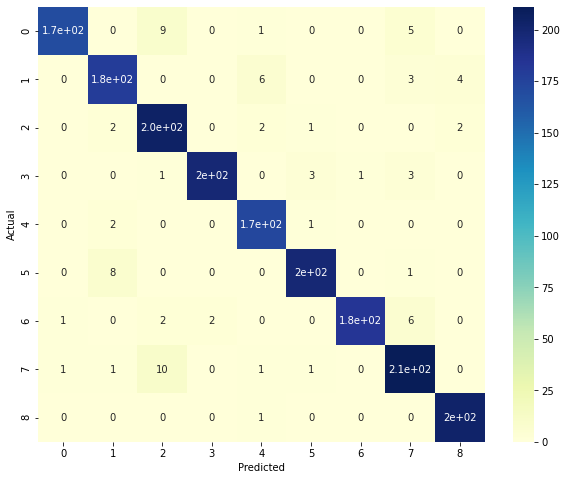

In [117]:
confusion_mtx = confusion_matrix(test.labels,pred) 
plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx,annot=True,annot_kws={"size": 10} , cmap="YlGnBu")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.plot()

In [118]:
print(classification_report(test.labels,pred))

              precision    recall  f1-score   support

           0       0.99      0.92      0.95       184
           1       0.93      0.93      0.93       192
           2       0.90      0.97      0.93       212
           3       0.99      0.96      0.98       206
           4       0.94      0.98      0.96       176
           5       0.97      0.96      0.96       207
           6       0.99      0.94      0.97       194
           7       0.92      0.94      0.93       225
           8       0.97      1.00      0.98       204

    accuracy                           0.95      1800
   macro avg       0.96      0.95      0.96      1800
weighted avg       0.96      0.95      0.96      1800



# Testing model with database images

In [119]:
from tensorflow.keras.preprocessing import image
def predict_it(image_location):
  test_image=image.load_img(image_location, target_size = (200,200))
  plt.imshow(test_image)
  test_image=image.img_to_array(test_image)   #Converts a Image instance to a Numpy array.
  test_image=test_image/255
  test_image = np.expand_dims(test_image, axis = 0)   #Expands the shape of an array.
  preds=np.argmax(model.predict(test_image))
  print(f'The fish is {list(test.class_indices.keys())[preds]}')


The fish is Black Sea Sprat


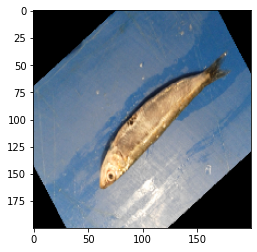

In [120]:
predict_it('../input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/Black Sea Sprat/Black Sea Sprat/00001.png')

The fish is Gilt-Head Bream


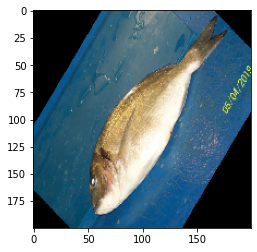

In [121]:
predict_it('../input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/Gilt-Head Bream/Gilt-Head Bream/00001.png')

The fish is Red Mullet


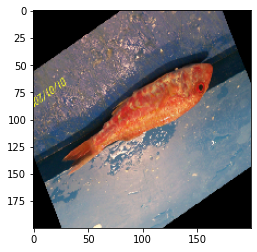

In [122]:
predict_it('../input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/Red Mullet/Red Mullet/00001.png')

The fish is Shrimp


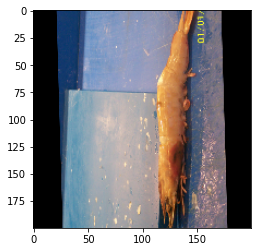

In [123]:
predict_it('../input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00001.png')

# Testing model with online images using URL

In [124]:
from urllib.request import urlopen
from PIL import Image

In [125]:
def predict_url(url):
  img = Image.open(urlopen(url))
  plt.imshow(img)
  test_image=image.img_to_array(img)
  test_image=tf.image.resize(test_image, (200, 200))
  
  test_image=test_image/255
  test_image = np.expand_dims(test_image, axis = 0)
  preds=np.argmax(model.predict(test_image))
  print(f'The fish is {list(test.class_indices.keys())[preds]}')

The fish is Trout


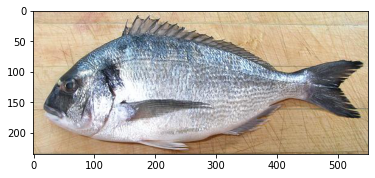

In [126]:
predict_url('http://www.clovegarden.com/ingred/img/sf_seabrm03g.jpg')

The fish is Red Mullet


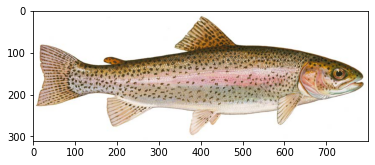

In [127]:
predict_url('https://img3.exportersindia.com/product_images/bc-full/dir_14/401539/trout-fish-1538328.jpg')

The fish is Trout


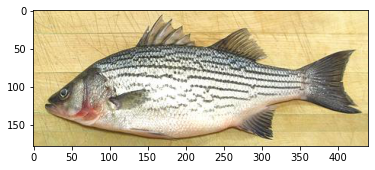

In [128]:
predict_url('http://www.clovegarden.com/ingred/img/sf_bassst13g.jpg')